# 🔄 Agent Workflows with Microsoft Agent Framework (Python)

## 📋 What You'll Learn

This notebook shows you how to create multi-agent workflows where multiple AI agents work together in sequence. You'll build a simple travel recommendation workflow with two agents: a front desk agent and a reviewer agent.

**What's Inside:**
- 🏗️ **Workflow Builder**: Chain multiple agents together
- 📊 **Workflow Visualization**: See your workflow as a diagram
- 🔄 **Event-Driven Execution**: Process workflow results step by step
- 🤝 **Multi-Agent Coordination**: Agents reviewing each other's work

## ⚙️ Setup Requirements

### 1. **Docker & Dev Container**
- Install Docker on your machine
- Open this project in the dev container (VS Code will prompt you)

### 2. **Workspace Configuration**
- Open the workspace: `File > Open Workspace from File` → select `workspace.code-workspace`
- This sets up the correct Python environment for each project folder

### 3. **Environment Variables**
1. Copy `.env.example` to `.env` in the `agent-framework-samples` folder:
   ```bash
   cp .env.example .env
   ```
2. Fill in your Azure credentials:
   ```env
   # Azure OpenAI (Required for this example)
   AZURE_OPENAI_ENDPOINT=your_endpoint
   AZURE_OPENAI_CHAT_DEPLOYMENT_NAME=your_deployment
   ```

### 4. **System Dependencies**
The notebook will install graphviz automatically for workflow visualization.

## 🚀 What You'll Build

A simple workflow with two agents:

```
User Request → Front Desk Agent → Reviewer Agent → Final Response
```

1. **Front Desk Agent**: Provides travel recommendations
2. **Reviewer Agent**: Reviews and validates the recommendations

You'll see:
- How to define agent instructions
- How to connect agents in a workflow
- How to visualize the workflow structure
- How to run the workflow and process results

Let's build a collaborative agent workflow! 🌟

In [1]:
# 🔄 Import Workflow and Agent Framework Components
# Core components for building sophisticated agent workflows

from agent_framework.openai import OpenAIChatClient    # 🤖 GitHub Models client integration
from agent_framework import WorkflowBuilder, WorkflowEvent, WorkflowViz , ChatMessage, ConcurrentBuilder# 🏗️ Workflow orchestration tools
from dotenv import load_dotenv  
from agent_framework import ChatAgent
from azure.identity import AzureCliCredential, DefaultAzureCredential
from agent_framework.azure import AzureOpenAIChatClient
from agent_framework.openai import OpenAIChatClient
import os                      # 🔧 Environment variable access
from agent_framework.openai import OpenAIChatClient
from agent_framework import ChatMessage, DataContent, Role, TextContent,WorkflowBuilder,  WorkflowEvent,WorkflowViz, WorkflowOutputEvent
from pydantic import BaseModel
import os
import json
import base64
from dotenv import load_dotenv

from IPython.display import SVG, display, HTML
import os
from typing import Any, List
from IPython.display import SVG, display, HTML
from azure.ai.projects.aio import AIProjectClient
from agent_framework.azure import AzureAIAgentClient
load_dotenv()

True

In [2]:
# Step 1: Create the Azure OpenAI client
chat_client = AzureOpenAIChatClient(credential=DefaultAzureCredential())

# Step 2: Create agents with instructions defined inline

# Travel workflow agents
reviewer_agent = chat_client.create_agent(
    name="Concierge",
    instructions="""
        You are an are hotel concierge who has opinions about providing the most local and authentic experiences for travelers.
        The goal is to determine if the front desk travel agent has recommended the best non-touristy experience for a traveler.
        If so, state that it is approved.
        If not, provide insight on how to refine the recommendation without using a specific example. 
    """
)

front_desk_agent = chat_client.create_agent(
    name="FrontDesk",
    instructions="""
        You are a Front Desk Travel Agent with ten years of experience and are known for brevity as you deal with many customers.
        The goal is to provide the best activities and locations for a traveler to visit.
        Only provide a single recommendation per response.
        You're laser focused on the goal at hand.
        Don't waste time with chit chat.
        Consider suggestions when refining an idea.
    """
)

# Travel research workflow agents
research_agent = chat_client.create_agent(
    name="Researcher-Agent",
    instructions="You are my travel researcher, working with me to analyze the destination, list relevant attractions, and make detailed plans for each attraction."
)

plan_agent = chat_client.create_agent(
    name="Plan-Agent",
    instructions="You are my travel planner, working with me to create a detailed travel plan based on the researcher's findings."
)

class AggregatorFormat(BaseModel):
    class steps(BaseModel):
        attraction_name: str
        activity_description: str
    
    destination: str
    itinerary_steps: List[steps]

aggregator_agent = chat_client.create_agent(
    name="Aggregator-Agent",
    instructions="You are my travel plan aggregator, working with me to combine all the detailed plans into a single comprehensive itinerary.",
    response_format=AggregatorFormat
)

async def aggregate(results) -> AggregatorFormat: 
    agents_responses = " | ".join(r.agent_run_response.messages[-1].text for r in results)
    aggregation_result = await aggregator_agent.run(agents_responses)
    return AggregatorFormat.model_validate_json(aggregation_result.text)

# Furniture workflow agents
sales_agent = chat_client.create_agent(
    name="Sales-Agent",
    instructions="You are my furniture sales consultant, you can find different furniture elements from the pictures and give me a purchase suggestion"
)

price_agent = chat_client.create_agent(
    name="Price-Agent",
    instructions="""You are a furniture pricing specialist and budget consultant. Your responsibilities include:
        1. Analyze furniture items and provide realistic price ranges based on quality, brand, and market standards
        2. Break down pricing by individual furniture pieces
        3. Provide budget-friendly alternatives and premium options
        4. Consider different price tiers (budget, mid-range, premium)
        5. Include estimated total costs for room setups
        6. Suggest where to find the best deals and shopping recommendations
        7. Factor in additional costs like delivery, assembly, and accessories
        8. Provide seasonal pricing insights and best times to buy
        Always format your response with clear price breakdowns and explanations for the pricing rationale."""
)

quote_agent = chat_client.create_agent(
    name="Quote-Agent",
    instructions="""You are a assistant that create a quote for furniture purchase.
        1. Create a well-structured quote document that includes:
        2. A title page with the document title, date, and client name
        3. An introduction summarizing the purpose of the document
        4. A summary section with total estimated costs and recommendations
        5. Use clear headings, bullet points, and tables for easy readability
        6. All quotes are presented in markdown form"""
)

In [3]:
# Helper Functions for Workflow Visualization

def print_workflow_viz(workflow, title="Workflow Visualization"):
    """
    Display workflow visualization in multiple formats (Mermaid, DiGraph, SVG).
    
    Args:
        workflow: The workflow object to visualize
        title: Optional title for the visualization output
    """
    print(f"\n{'=' * 80}")
    print(f"🎨 {title}")
    print('=' * 80)
    
    viz = WorkflowViz(workflow)
    
    # Print Mermaid format
    print("\n📊 Mermaid Diagram:")
    print('-' * 80)
    print(viz.to_mermaid())
    print('-' * 80)
    
    # Print DiGraph format
    print("\n🔗 DiGraph:")
    print('-' * 80)
    print(viz.to_digraph())
    print('-' * 80)
    
    # Export and display SVG
    svg_file = viz.export(format="svg")
    print(f"\n💾 SVG exported to: {svg_file}")
    
    # Display the SVG
    display_svg(svg_file)
    
    return svg_file


def display_svg(svg_file):
    """
    Display an SVG file in the notebook with fallback rendering.
    
    Args:
        svg_file: Path to the SVG file
    """
    print(f"\n🖼️ Displaying SVG: {svg_file}")
    
    if not svg_file or not os.path.exists(svg_file):
        print("❌ SVG file not found.")
        return
    
    try:
        # Try direct SVG rendering
        display(SVG(filename=svg_file))
    except Exception as e:
        print(f"⚠️ Direct SVG render failed: {e}")
        print("Attempting HTML fallback...")
        try:
            # Fallback to HTML rendering
            with open(svg_file, "r", encoding="utf-8") as f:
                svg_text = f.read()
            display(HTML(svg_text))
            print("✅ SVG displayed via HTML fallback")
        except Exception as inner:
            print(f"❌ HTML fallback also failed: {inner}")


def print_workflow_event(event, index=None):
    """
    Print workflow event with formatted output based on event type.
    
    Args:
        event: The workflow event to display
        index: Optional index number for the event
    """
    
    # Header with index if provided
    header = f"\n{'=' * 80}\n"
    if index is not None:
        header += f"📋 Event #{index}\n"
    else:
        header += f"📋 Workflow Event\n"
    header += f"{'=' * 80}"
    print(header)
    
    # Check if this is a WorkflowOutputEvent (special handling)
    if isinstance(event, WorkflowOutputEvent):
        print(f"🎯 Event Type: WorkflowOutputEvent")
        
        if event.source_executor_id:
            print(f"   🤖 Executor: {event.source_executor_id}")
        
        if hasattr(event, 'data') and event.data:
            print(f"   📦 Output Data:")
            print(f"   {'-' * 76}")
            
            # Handle different data types
            if isinstance(event.data, str):
                # String data - try to parse as JSON
                try:
                    parsed_data = json.loads(event.data)
                    print(f"   {json.dumps(parsed_data, indent=6)}")
                except (json.JSONDecodeError, TypeError):
                    # Not JSON, print as-is
                    print(f"   {event.data}")
            elif isinstance(event.data, BaseModel):
                # Pydantic model - use model_dump_json
                print(f"   {event.data.model_dump_json(indent=6)}")
            elif hasattr(event.data, '__dict__'):
                # Object with __dict__ - try to serialize
                try:
                    print(f"   {json.dumps(event.data.__dict__, indent=6, default=str)}")
                except Exception:
                    print(f"   {event.data}")
            else:
                # Default: just print the data
                print(f"   {event.data}")
    else:
        # Standard WorkflowEvent
        print(f"⚙️  Event Type: {type(event).__name__}")
        
        if event.executor_id:
            print(f"   🤖 Executor ID: {event.executor_id}")
        
        if event.origin:
            print(f"   📍 Source: {event.origin}")
        
        if hasattr(event, 'data') and event.data is not None:
            # Check if data has a text attribute
            if hasattr(event.data, 'text'):
                content = event.data.text
                print(f"   💬 Content:")
                print(f"   {'-' * 76}")
                # Indent the content for better readability
                for line in content.split('\n'):
                    print(f"   {line}")
            else:
                print(f"   📦 Data: {event.data}")
        else:
            print(f"   ⚠️  No data available")
    
    print(f"{'=' * 80}")



🎨 Sequential Travel Workflow

📊 Mermaid Diagram:
--------------------------------------------------------------------------------
flowchart TD
  FrontDesk["FrontDesk (Start)"];
  Concierge["Concierge"];
  FrontDesk --> Concierge;
--------------------------------------------------------------------------------

🔗 DiGraph:
--------------------------------------------------------------------------------
digraph Workflow {
  rankdir=TD;
  node [shape=box, style=filled, fillcolor=lightblue];
  edge [color=black, arrowhead=vee];

  "FrontDesk" [fillcolor=lightgreen, label="FrontDesk\n(Start)"];
  "Concierge" [label="Concierge"];
  "FrontDesk" -> "Concierge";
}
--------------------------------------------------------------------------------

💾 SVG exported to: /tmp/tmpwylvt4zf.svg

🖼️ Displaying SVG: /tmp/tmpwylvt4zf.svg


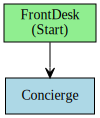


🎯 Running workflow with request: 'I would like to go to Paris.'

✅ Final workflow result:
Visit the Louvre Museum.This recommendation leans toward a classic tourist attraction. To refine the experience, I suggest exploring lesser-known spots, focusing on activities that allow for genuine interactions with locals, and seeking out places where the daily rhythms of Parisian life are evident beyond the major landmarks.

✅ Final workflow result:
Visit the Louvre Museum.This recommendation leans toward a classic tourist attraction. To refine the experience, I suggest exploring lesser-known spots, focusing on activities that allow for genuine interactions with locals, and seeking out places where the daily rhythms of Parisian life are evident beyond the major landmarks.


In [4]:
# Step 4: Build and visualize the workflow

# Define a custom event type for our workflow
class DatabaseEvent(WorkflowEvent): ...

# Build the workflow: front_desk_agent → reviewer_agent
workflow = (WorkflowBuilder()
    .set_start_executor(front_desk_agent)  # Start with front desk agent
    .add_edge(front_desk_agent, reviewer_agent)  # Then go to reviewer agent
    .build())

# Use helper function to visualize
print_workflow_viz(workflow, title="Sequential Travel Workflow")

# Step 5: Run the workflow with a travel request
print("\n🎯 Running workflow with request: 'I would like to go to Paris.'")
result = ''

async for event in workflow.run_stream('I would like to go to Paris.'):
    # Collect workflow output from events
    if isinstance(event, DatabaseEvent):
        print(f"{event}")
    if isinstance(event, WorkflowEvent):
        result += str(event.data)
        
# Clean up and display final result
result = result.replace("None", "")
print("\n✅ Final workflow result:")
print(result)



🎨 Concurrent Travel Research Workflow

📊 Mermaid Diagram:
--------------------------------------------------------------------------------
flowchart TD
  dispatcher["dispatcher (Start)"];
  Researcher_Agent["Researcher-Agent"];
  Plan_Agent["Plan-Agent"];
  aggregate["aggregate"];
  fan_in__aggregate__53665906((fan-in))
  Plan_Agent --> fan_in__aggregate__53665906;
  Researcher_Agent --> fan_in__aggregate__53665906;
  fan_in__aggregate__53665906 --> aggregate;
  dispatcher --> Researcher_Agent;
  dispatcher --> Plan_Agent;
--------------------------------------------------------------------------------

🔗 DiGraph:
--------------------------------------------------------------------------------
digraph Workflow {
  rankdir=TD;
  node [shape=box, style=filled, fillcolor=lightblue];
  edge [color=black, arrowhead=vee];

  "dispatcher" [fillcolor=lightgreen, label="dispatcher\n(Start)"];
  "Researcher-Agent" [label="Researcher-Agent"];
  "Plan-Agent" [label="Plan-Agent"];
  "aggregate" [l

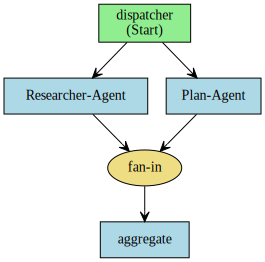


🔄 Processing workflow events...

📋 Event #1
⚙️  Event Type: ExecutorInvokedEvent
   🤖 Executor ID: dispatcher
   📍 Source: WorkflowEventSource.FRAMEWORK
   ⚠️  No data available

📋 Event #2
⚙️  Event Type: ExecutorCompletedEvent
   🤖 Executor ID: dispatcher
   📍 Source: WorkflowEventSource.FRAMEWORK
   ⚠️  No data available

📋 Event #3
⚙️  Event Type: ExecutorInvokedEvent
   🤖 Executor ID: Researcher-Agent
   📍 Source: WorkflowEventSource.FRAMEWORK
   ⚠️  No data available

📋 Event #4
⚙️  Event Type: ExecutorInvokedEvent
   🤖 Executor ID: Plan-Agent
   📍 Source: WorkflowEventSource.FRAMEWORK
   ⚠️  No data available

📋 Event #5
⚙️  Event Type: AgentRunEvent
   🤖 Executor ID: Plan-Agent
   📍 Source: WorkflowEventSource.EXECUTOR
   💬 Content:
   ----------------------------------------------------------------------------
   Absolutely! Seattle in December is festive and full of unique winter charm. Here’s a detailed travel plan tailored to the season. If you want to specify number of tr

In [ ]:
# Concurrent Agents Workflow Example with Fan In aggregation

# Build concurrent workflow with research and plan agents
workflow = ConcurrentBuilder().participants([research_agent, plan_agent]).with_aggregator(aggregate).build()

# Use helper function to visualize
print_workflow_viz(workflow, title="Concurrent Travel Research Workflow")

# Run the workflow
events = await workflow.run("Plan a trip to Seattle in December")

# Display each event with formatted output
print("\n🔄 Processing workflow events...")
for i, event in enumerate(events, start=1):
    print_workflow_event(event, index=i)


In [ ]:
# Furniture Quote Workflow with Vision Analysis

# Build sequential workflow: sales → price → quote
workflow = WorkflowBuilder().set_start_executor(sales_agent).add_edge(sales_agent, price_agent).add_edge(price_agent, quote_agent).build()

# Define custom event type
class DatabaseEvent(WorkflowEvent): ...

# Use helper function to visualize
print_workflow_viz(workflow, title="Furniture Quote Workflow")

# Load and encode the image
image_path = "files/imgs/home.png"
with open(image_path, "rb") as image_file:
    image_b64 = base64.b64encode(image_file.read()).decode()
image_uri = f"data:image/png;base64,{image_b64}"

# Create message with image
message = ChatMessage(
    role=Role.USER,
    contents=[
        TextContent(text="Please find the relevant furniture according to the image and give the corresponding price for each piece of furniture"),
        DataContent(uri=image_uri, media_type="image/png")
    ]
)

# Run workflow and collect results
result = ''
async for event in workflow.run_stream(message):
    if isinstance(event, DatabaseEvent):
        print(f"{event}")
    if isinstance(event, WorkflowEvent):
        result += str(event.data)

# Clean up and display final result
result = result.replace("None", "")
print("\n✅ Workflow Result:")
print("=" * 80)
print(result)
